In [160]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
from astropy.table import Table, join
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from scipy.spatial import cKDTree
import os
import sys
import glob

In [161]:
# initial_values = Table.read('../spectrum_analysis/galah_dr4_initial_parameters_220714_lite.fits')
initial_values = Table.read('../catalogs/galah_dr4_allstar_230531.fits')
# initial_values = Table.read('../spectrum_post_processing/galah_dr4_allspec_not_validated.fits')

In [162]:
grids = Table.read('galah_dr4_model_trainingset_gridpoints.fits')

In [163]:
grids['model_name'] = np.array([str(int(grid['teff_subgrid']))+'_'+str("{:.2f}".format(grid['logg_subgrid']))+'_'+str("{:.2f}".format(grid['fe_h_subgrid'])) for grid in grids])

In [164]:
grid_index_tree = cKDTree(np.c_[grids['teff_subgrid']/1000.,grids['logg_subgrid'],grids['fe_h_subgrid']])

In [165]:
initial_values['grid_index'] = np.array([grid_index_tree.query([tgf[0]/1000.,tgf[1],tgf[2]]) for tgf in np.array([initial_values['teff'],initial_values['logg'],initial_values['fe_h']]).T])[:,1]

In [166]:
indices = initial_values['grid_index']
priority = Table()
d,c = np.unique(indices, return_counts=True)
priority['index_subgrid'] = np.array(d,dtype=int)
priority['counts_dr4_init'] = np.array(c,dtype=int)
priority = join(priority, grids, keys='index_subgrid')
priority.sort(keys='counts_dr4_init',reverse=True)

In [167]:
len(np.where(initial_values['grid_index'] == 2500)[0])

5

In [168]:
def test_grid_index_computations(test_grid_index = 1931, print_all_points=False,print_needed=True):
    if print_all_points:
        print('Printing grid points not yet computed for '+str(grids['model_name'][test_grid_index])+':')

    # Find upper and lower Teff points
    test_grid_teff = int(grids['teff_subgrid'][test_grid_index])
    if test_grid_teff <= 4000:
        test_grid_teff_lower = test_grid_teff - 100
    else:
        test_grid_teff_lower = test_grid_teff - 250
    if test_grid_teff <= 3900:
        test_grid_teff_higher = test_grid_teff + 100
    else:
        test_grid_teff_higher = test_grid_teff + 250

    # Find upper and lower logg points
    test_grid_logg = grids['logg_subgrid'][test_grid_index]
    test_grid_logg_lower = test_grid_logg - 0.5
    test_grid_logg_higher = test_grid_logg + 0.5

    # Find upper and lower fe_h points
    test_grid_fe_h = grids['fe_h_subgrid'][test_grid_index]
    if test_grid_fe_h <= -1.00:
        test_grid_fe_h_lower = test_grid_fe_h - 0.5
    else:
        test_grid_fe_h_lower = test_grid_fe_h - 0.25
    if test_grid_fe_h <= -1.5:
        test_grid_fe_h_higher = test_grid_fe_h + 0.5
    else:
        test_grid_fe_h_higher = test_grid_fe_h + 0.25
        
    needs_to_be_computed = []

    for teff in [test_grid_teff_lower,test_grid_teff,test_grid_teff_higher]:
        for logg in [test_grid_logg_lower,test_grid_logg,test_grid_logg_higher]:
            for fe_h in [test_grid_fe_h_lower,test_grid_fe_h,test_grid_fe_h_higher]:
                t = grids['index_subgrid'][grids['model_name'] == str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h)]
                if len(t) > 0:
                    if t[0] not in grids_done:
                        if t[0] not in grids_started:
                            if print_all_points:
                                print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h))
                            else:
                                if print_needed: print(str(t[0])+',')
                                needs_to_be_computed.append(t[0])
                        else:
                            if print_all_points:
                                print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h), 'already started')
                    else:
                        if print_all_points:
                            print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h), 'already done')
                else:
                    if print_all_points:
                        print('Not in GRID :', str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h))
                    
    return(needs_to_be_computed)

In [20]:
def test_grid_index_ready_for_training(test_grid_index = 1931, print_all_points=False,):
    if print_all_points:
        print('Printing grid points not yet computed for '+str(grids['model_name'][test_grid_index])+':')

    # Find upper and lower Teff points
    test_grid_teff = int(grids['teff_subgrid'][test_grid_index])
    if test_grid_teff <= 4000:
        test_grid_teff_lower = test_grid_teff - 100
    else:
        test_grid_teff_lower = test_grid_teff - 250
    if test_grid_teff <= 3900:
        test_grid_teff_higher = test_grid_teff + 100
    else:
        test_grid_teff_higher = test_grid_teff + 250

    # Find upper and lower logg points
    test_grid_logg = grids['logg_subgrid'][test_grid_index]
    test_grid_logg_lower = test_grid_logg - 0.5
    test_grid_logg_higher = test_grid_logg + 0.5

    # Find upper and lower fe_h points
    test_grid_fe_h = grids['fe_h_subgrid'][test_grid_index]
    if test_grid_fe_h <= -1.00:
        test_grid_fe_h_lower = test_grid_fe_h - 0.5
    else:
        test_grid_fe_h_lower = test_grid_fe_h - 0.25
    if test_grid_fe_h <= -1.5:
        test_grid_fe_h_higher = test_grid_fe_h + 0.5
    else:
        test_grid_fe_h_higher = test_grid_fe_h + 0.25

    for teff in [test_grid_teff_lower,test_grid_teff,test_grid_teff_higher]:
        for logg in [test_grid_logg_lower,test_grid_logg,test_grid_logg_higher]:
            for fe_h in [test_grid_fe_h_lower,test_grid_fe_h,test_grid_fe_h_higher]:
                t = grids['index_subgrid'][grids['model_name'] == str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h)]
                if len(t) > 0:
                    if t[0] not in grids_converted_to_nn_input:
                        print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h),' not ready')
                    else:
                        print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h),' done')
                else:
                    if print_all_points:
                        print('Not in GRID :', str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h))
                    

In [21]:
def test_progress(print_train_only=False):
    
    number_points_calculated_all = []
    number_points_needed_all = []
    
    train_suggestion = []
    
    for test_grid_index in grids['index_subgrid']:#[grids_converted_to_nn_input]:

        # Find upper and lower Teff points
        test_grid_teff = int(grids['teff_subgrid'][test_grid_index])
        if test_grid_teff <= 4000:
            test_grid_teff_lower = test_grid_teff - 100
        else:
            test_grid_teff_lower = test_grid_teff - 250
        if test_grid_teff <= 3900:
            test_grid_teff_higher = test_grid_teff + 100
        else:
            test_grid_teff_higher = test_grid_teff + 250

        # Find upper and lower logg points
        test_grid_logg = grids['logg_subgrid'][test_grid_index]
        test_grid_logg_lower = test_grid_logg - 0.5
        test_grid_logg_higher = test_grid_logg + 0.5

        # Find upper and lower fe_h points
        test_grid_fe_h = grids['fe_h_subgrid'][test_grid_index]
        if test_grid_fe_h <= -1.00:
            test_grid_fe_h_lower = test_grid_fe_h - 0.5
        else:
            test_grid_fe_h_lower = test_grid_fe_h - 0.25
        if test_grid_fe_h <= -1.5:
            test_grid_fe_h_higher = test_grid_fe_h + 0.5
        else:
            test_grid_fe_h_higher = test_grid_fe_h + 0.25

        number_points_calculated_each = 0
        number_points_needed_each = 0
        next_needed = None
        
        for teff in [test_grid_teff_lower,test_grid_teff,test_grid_teff_higher]:
            for logg in [test_grid_logg_lower,test_grid_logg,test_grid_logg_higher]:
                for fe_h in [test_grid_fe_h_lower,test_grid_fe_h,test_grid_fe_h_higher]:
                    
                    t = grids['index_subgrid'][grids['model_name'] == str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h)]
                    
                    if len(t) > 0:
                        number_points_needed_each += 1
                        if t[0] in grids_converted_to_nn_input:
                            number_points_calculated_each += 1
                        else:
                            next_needed = t[0]
                    else:
                        # there is no grid point for this one.
                        pass

        number_points_calculated_all.append(number_points_calculated_each)
        number_points_needed_all.append(number_points_needed_each)
        
        try:
            counts = priority['counts_dr4_init'][priority['index_subgrid']==test_grid_index][0]
            if counts < 10:
                counts = str(counts)+'    '
            elif counts < 100:
                counts = str(counts)+'   '
            elif counts < 1000:
                counts = str(counts)+'  '
            elif counts < 10000:
                counts = str(counts)+' '
            else:
                counts = str(counts)
        except:
            counts = 'none '
            
        space = ''
        if test_grid_fe_h >= 0:
            space = ' '

        if number_points_calculated_each == number_points_needed_each:
            if test_grid_index in trained_3x3x3:
                pass
                # print(str(test_grid_index)+' trained 3x3x3')
            else:
                print(str(test_grid_index)+' '+str(int(test_grid_teff))+'_'+"{:.2f}".format(test_grid_logg)+'_'+"{:.2f}".format(test_grid_fe_h)+space+' '+counts+' -----------------------------------------------------      TRAIN!!!')
                train_suggestion.append(test_grid_index)
        elif number_points_calculated_each > number_points_needed_each - 7:
            if next_needed in grids_done:
                if not print_train_only:
                    print(str(test_grid_index)+' '+str(int(test_grid_teff))+'_'+"{:.2f}".format(test_grid_logg)+'_'+"{:.2f}".format(test_grid_fe_h)+space+' '+counts+' only '+str(number_points_needed_each - number_points_calculated_each)+' more:', next_needed, '                             CONVERT')
            elif next_needed in grids_started:
                if not print_train_only:
                    print(str(test_grid_index)+' '+str(int(test_grid_teff))+'_'+"{:.2f}".format(test_grid_logg)+'_'+"{:.2f}".format(test_grid_fe_h)+space+' '+counts+' only '+str(number_points_needed_each - number_points_calculated_each)+' more:', next_needed, '                PBS running')
            else:
                if not print_train_only:
                    print(str(test_grid_index)+' '+str(int(test_grid_teff))+'_'+"{:.2f}".format(test_grid_logg)+'_'+"{:.2f}".format(test_grid_fe_h)+space+' '+counts+' only '+str(number_points_needed_each - number_points_calculated_each)+' more:', next_needed, ' Submit to PBS!')
    print(list(train_suggestion))

In [643]:
grids_started = [ 
]
print(len(grids_started))

0


In [645]:
grids_done = [
    0,1,2,3,4,5,6,7,8,9,
    10,
    13,14,15,16,17,18,19,
    20,
    81,82,83,84,85,86,87,88,
    93,94,95,96,97,98,99,
    100,
    104,105,106,107,108,109,
    110,111,112,113,114,115,116,117,118,119,
    120,121,122,123,124,125,126,127,128,129,
    130,131,132,133,134,135,
    198,199,
    200,201,202,203,204,205,
    210,211,212,213,214,215,216,217,
    222,223,224,225,226,227,228,229,
    230,231,232,233,234,235,236,237,238,239,
    240,241,242,243,244,245,246,247,248,249,
    250,251,252,253,254,255,256,257,258,259,
    260,261,
    312,313,314,315,316,317,
    323,324,325,326,327,328,329,
    330,331,
    335,336,337,338,339,
    340,341,342,343,
    347,348,349,
    350,351,352,353,354,355,
    356,357,358,359,
    360,361,362,363,364,365,366,367,368,369,
    370,371,372,373,374,375,376,377,378,379,
    380,381,382,383,384,385,386,387,
    392,393,394,395,396,397,
    438,439,
    440,441,442,443,
    448,449,
    450,451,452,453,454,455,456,457,
    460,461,462,463,464,465,466,467,468,469,
    472,473,474,475,476,477,478,479,
    480,481,482,483,484,485,486,487,488,489,
    490,491,492,493,494,495,496,497,498,499,
    500,501,502,503,504,505,506,507,508,509,
    510,511,512,513,514,
    516,517,518,519,
    520,521,522,523,524,
    564,565,566,567,568,569,
    570,
    575,576,577,578,579,
    580,581,582,583,
    587,588,589,
    590,591,592,593,594,595,
    599,
    600,601,602,603,604,605,606,607,
    609,
    610,611,612,613,614,615,616,617,618,619,
    620,621,622,623,624,625,626,627,628,629,
    630,631,632,633,634,635,636,637,638,639,
    641,642,643,644,645,646,647,648,649,
    688,689,
    690,691,692,693,694,695,
    699,
    700,701,702,703,704,705,706,707,708,
    711,712,713,714,715,716,717,718,719,
    720,
    723,724,725,726,727,728,729,
    730,731,732,
    734,735,736,737,738,739,
    740,741,742,743,744,745,746,747,748,749,
    750,751,752,753,754,755,756,757,758,759,
    760,761,762,763,764,765,766,767,768,769,
    770,771,772,773,
    779,
    780,781,782,783,
    812,813,814,815,816,817,818,819,
    823,824,825,826,827,828,829,
    830,831,832,
    834,835,836,837,838,839,
    840,841,842,843,
    845,846,847,848,849,
    850,851,852,853,854,
    856,857,858,859,
    862,863,864,865,866,867,868,869,
    870,871,872,873,874,875,876,877,878,879,
    880,881,882,883,884,885,886,887,888,889,
    890,891,892,893,894,895,
    900,901,902,903,904,905,906,907,
    934,935,936,937,938,939,
    940,941,942,
    945,946,947,948,949,
    950,951,952,953,954,
    957,958,959,
    960,961,962,963,964,965,966,
    969,
    970,971,972,973,974,975,976,977,978,
    980,981,982,983,
    986,987,988,989,
    990,991,992,993,994,
    996,997,998,999,
    1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,
    1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,
    1023,1024,1025,1026,1027,1028,1029,
    1030,1031,
    1037,1038,1039,
    1040,1041,1042,1043,
    1059,
    1060,1061,1062,1063,1064,1065,1066,
    1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,
    1081,1082,1083,1084,1085,1086,1087,1088,1089,
    1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,
    1100,1101,1102,1103,1104,1105,
    1109,1110,1111,1112,1113,1114,1115,1116,1117,
    1119,
    1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,
    1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,
    1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,
    1150,1151,1152,1153,1154,1155,1156,1157,1158,1159,
    1160,1161,1162,1163,1164,1165,1166,1167,1168,
    1171,1172,1173,1174,1175,1176,1177,1178,
    1183,1184,1185,1186,1187,1188,1189,
    1193,1194,1195,1196,1197,1198,1199,
    1200,1201,1202,
    1205,1206,1207,1208,1209,
    1210,1211,1212,1213,1214,
    1216,1217,1218,1219,
    1220,1221,1222,1223,1224,1225,1226,1227,
    1231,1232,1233,1234,1235,1236,1237,1238,1239,
    1241,1242,1243,1244,1245,1246,1247,1248,1249,
    1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,
    1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,
    1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,
    1280,1281,1282,1283,1284,1285,1286,1287,1288,1289,
    1290,1291,1292,1293,1294,1295,1296,1297,1298,1299,
    1300,
    1304,1305,1306,1307,1308,1309,
    1310,1311,1312,
    1315,1316,1317,1318,1319,
    1320,1321,1322,1323,1324,
    1327,1328,1329,
    1330,1331,1332,1333,1334,1335,1336,1337,
    1340,1341,1342,1343,1344,1345,1346,1347,
    1350,1351,1352,1353,1354,1355,1356,1357,1358,1359,
    1360,1361,1362,1363,1364,1365,1366,1367,1368,1369,
    1370,1371,1372,1373,1374,1375,1376,1377,1378,1379,
    1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,
    1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,
    1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,
    1412,1413,1414,1415,1416,1417,1418,1419,
    1420,1421,
    1424,1425,1426,1427,1428,1429,
    1430,1431,1432,1433,
    1436,1437,1438,1439,
    1440,1441,1442,1443,1444,1445,
    1446,1447,1448,1449,
    1450,
    1456,1457,1458,1459,
    1460,1461,1462,1463,1464,1465,
    1468,1469,
    1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,
    1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,
    1490,1491,1492,1493,1494,1495,1496,1497,1498,1499,
    1500,1501,1502,1503,1504,1505,1506,1507,1508,1509,
    1510,1511,1512,1513,1514,1515,1516,1517,1518,1519,
    1520,1521,1522,1523,1524,1525,1526,1527,
    1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,
    1542,1543,1544,1545,1546,1547,1548,1549,
    1550,1551,1552,1553,1554,
    1559,
    1560,1561,1562,1563,1564,1565,1566,
    1571,1572,1573,1574,1575,1576,1577,1578,1579,
    1580,1581,
    1583,1584,1585,1586,1587,1588,1589,
    1590,1591,1592,1593,1594,1595,1596,1597,1598,1599,
    1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,
    1610,1611,1612,1613,1614,1615,1616,1617,1618,1619,
    1620,1621,1622,1623,1624,
    1625,1626,1627,1628,1629,
    1630,
    1632,1633,1634,1635,1636,1637,1638,1639,
    1640,1641,1642,
    1644,1645,1646,1647,1648,1649,
    1650,1651,1652,1653,1654,
    1658,1659,
    1660,1661,1662,1663,
    1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,
    1682,1683,1684,1685,1686,1687,1688,1689,
    1690,1691,1692,
    1694,1695,1696,1697,1698,1699,
    1700,1701,1702,1703,1704,1705,1706,1707,1708,1709,
    1710,1711,1712,1713,1714,1715,1716,1717,1718,1719,
    1720,1721,1722,1723,1724,1725,1726,1727,1728,1729,
    1730,1731,1732,1733,1734,1735,1736,1737,1738,1739,
    1740,1741,
    1743,1744,1745,1746,1747,1748,1749,
    1750,1751,1752,1753,1754,1755,
    1765,1766,1767,1768,1769,
    1770,1771,
    1777,1778,1779,
    1780,1781,1782,1783,1784,1785,1786,1787,
    1789,
    1790,1791,1792,1793,1794,1795,1796,1797,1798,1799,
    1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,
    1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,
    1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,
    1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,
    1840,1841,1842,1843,1844,1845,1846,1847,1848,
    1851,1852,1853,1864,1865,
    1863,
    1866,1867,1868,
    1875,1876,1877,1878,1879,
    1880,1881,1882,1883,1884,1885,
    1887,1888,1889,
    1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,
    1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,
    1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,
    1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,
    1930,1931,1932,1933,1934,
    1938,
    1947,1948,1949,
    1950,
    1959,
    1960,1961,1962,1963,1964,1965,1966,1967,1968,
    1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,
    1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,
    1990,1991,1992,1993,
    1994,1995,1996,1997,1998,1999,
    2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,
    2010,2011,2012,2013,2014,2015,2016,2017,
    2026,2027,
    2037,2038,2039,
    2040,2041,2042,2043,2044,2045,
    2048,2049,
    2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,
    2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,
    2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,
    2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,
    2090,2091,2092,2093,2094,
    2108,2109,
    2110,2111,2112, 2113,2114,2115,2116,2117,
    2120,2121,2122,2123,2124,2125,2126,2127,2128,2129,
    2130,2131,2132,2133,2134,2135,2136,2137,2138,2139,
    2140,2141,2142,2143,2144,
    2145,2146,2147,2148,2149,
    2150,2151,2152,2153,2154,2155,2156,2157,2158,2159,
    2160,2161,2162,2163,2164,2165,2166,2167,
    2181,2182,2183,2184,2185,2186,2187,2188,2189,
    2193,2194,2195,2196,2197,2198,2199,
    2200,2201,2202,2203,2204,2205,2206,2207,2208,2209,
    2210,2211,2212,2213,2214,2215,2216,2217,2218,2219,
    2220,2221,2222,2223,2224,2225,2226,2227,2228,2229,
    2230,2231,2232,2233,2234,2235,2236,2237,2238,2239,
    2240,
    2255,2256,2257,2258,2259,
    2260,2261,
    2266,2267,2268,2269,
    2270,2271,2272,2273,2274,2275,2276,2277,2278,2279,
    2280,2281,2282,2283,2284,2285,2286,
    2288,2289,
    2290,2291,2292,2293,2294,2295,2296,2297,2298,
    2301,2302,2303,2304,2305,2306,2307,2308,2309,
    2310,
    2320,2321,2322,2323,2324,2325,2326,2327,
    2331,2332,2333,2334,2335,2336,2337,2338,2339,
    2340,2341,2342,2343,2344,2345,2346,2347,2348,2349,
    2350,2351,
    2353,2354,2355,2356,2357,2358,2359,
    2360,2361,2362,2363,
    2265,2366,2367,2368,2369,
    2370,2371,2372,2373,2374,2375,
    2381,2382,2383,2384,2385,2386,2387,2388,
    2393,2394,2395,2396,2397,2398,2399,
    2400,2401,2402,2403,2404,2405,2406,2407,2408,2409,
    2410,2411,2412,2413,2414,
    2416,2417,2418,2419,
    2420,2421,2422,2423,2424,2425,2426,
    2429,
    2430,2431,2432,2433,2434,2435,2436,2437,2438,
    2441,2442,2443,2444,2445,2446,2447,
    2452,2453,2454,2455,2456,2457,2458,2459,
    2460,2461,2462,
    2464,2465,2466,2467,2468,2469,
    2470,2471,2472,2473,2474,
    2476,2477,2478,2479,
    2480,2481,2482,2483,2484,2485,2486,
    2489,
    2490,2491,2492,2493,2494,2495,2496,2497,2498,2499,
    2500,2501,2502,2503,2504,2505,2506,2507,2508,2509,
    2510,2511,2512,2513,2514,2515,2516,2517,2518,2519,
    2520,2521,2522,2523,2524,2525,2526,2527,2528,2529,
    2530,2531,2532,2533,2534,2535,2536,2537,2538,2539,
    2540,2541,2542,2543,2544,2545,2546,
]
print(len(grids_done),len(grids_done) * 280)

1857 519960


In [646]:
selection = [
599, #  3500_5.00_-2.00
724, #  3600_5.00_-2.00
1093, #  3900_5.00_-2.00
1216, #  4000_5.00_-2.00
258, #  3300_1.00_0.50
342, #  3300_4.50_0.50
354, #  3300_5.00_0.50
363, #  3400_0.00_0.50
373, #  3400_0.50_0.50
384, #  3400_1.00_0.50
468, #  3400_4.50_0.50
480, #  3400_5.00_0.50
499, #  3500_0.50_0.50
511, #  3500_1.00_0.50
595, #  3500_4.50_0.50
607, #  3500_5.00_0.50
624, #  3600_0.50_0.50
636, #  3600_1.00_0.50
648, #  3600_1.50_0.50
720, #  3600_4.50_0.50
748, #  3700_0.50_0.50
760, #  3700_1.00_0.50
772, #  3700_1.50_0.50
843, #  3700_4.50_0.50
882, #  3800_1.00_0.50
894, #  3800_1.50_0.50
966, #  3800_4.50_0.50
1006, #  3900_1.00_0.50
1030, #  3900_2.00_0.50
1090, #  3900_4.50_0.50
1129, #  4000_1.00_0.50
1263, #  4250_1.50_0.50
]

# selection = np.concatenate((trained_3x3x3,selection))

needs_to_be_computed = []

for t in selection:
    print('# for ',t,grids['model_name'][t])
    new = test_grid_index_computations(t, print_needed=True)
    needs_to_be_computed.append(new)
#     if len(new) > 0:
#         print(str(t)+',')

needs_to_be_computed = np.array(np.concatenate(needs_to_be_computed),dtype=int)

# for  599 3500_5.00_-2.00
459,
471,
586,
598,
# for  724 3600_5.00_-2.00
586,
598,
# for  1093 3900_5.00_-2.00
1204,
1215,
# for  1216 4000_5.00_-2.00
1204,
1215,
1326,
# for  258 3300_1.00_0.50
143,
144,
145,
269,
270,
271,
# for  342 3300_4.50_0.50
# for  354 3300_5.00_0.50
# for  363 3400_0.00_0.50
# for  373 3400_0.50_0.50
# for  384 3400_1.00_0.50
269,
270,
271,
# for  468 3400_4.50_0.50
584,
596,
608,
# for  480 3400_5.00_0.50
596,
608,
# for  499 3500_0.50_0.50
# for  511 3500_1.00_0.50
# for  595 3500_4.50_0.50
584,
596,
608,
709,
721,
733,
# for  607 3500_5.00_0.50
596,
608,
721,
733,
# for  624 3600_0.50_0.50
# for  636 3600_1.00_0.50
# for  648 3600_1.50_0.50
534,
535,
536,
659,
660,
661,
784,
785,
# for  720 3600_4.50_0.50
584,
596,
608,
709,
721,
733,
833,
844,
855,
# for  748 3700_0.50_0.50
860,
861,
# for  760 3700_1.00_0.50
# for  772 3700_1.50_0.50
659,
660,
661,
784,
785,
# for  843 3700_4.50_0.50
709,
721,
733,
833,
844,
855,
955,
967,
979,
# for  882 3800_1.00_0.50

In [647]:
len(needs_to_be_computed), len(np.unique(needs_to_be_computed))

(88, 41)

In [648]:
nex = needs_to_be_computed
tnex = Table()
tnex['index'],tnex['counts'] = np.unique(nex,return_counts=True)
tnex['model'] = grids['model_name'][tnex['index']]
tnex.sort('counts',reverse=True)
# list(tnex['index'][:20])
print(str(len(tnex))+' to be computed')
# list(tnex[:20]['index'])
tnex[:20]

41 to be computed


index,counts,model
int64,int64,str15
596,5,3500_4.50_0.75
608,5,3500_5.00_0.75
721,4,3600_4.50_0.75
733,4,3600_5.00_0.75
855,3,3700_5.00_0.75
584,3,3500_4.00_0.75
709,3,3600_4.00_0.75
784,3,3700_2.00_0.50
785,3,3700_2.00_0.75


In [652]:
grids_converted_to_nn_input = [
    0,1,2,3,4,5,6,7,8,9,
    10,
    13,14,15,16,17,18,19,
    20,
    81,82,83,84,85,86,87,88,
    93,94,95,96,97,98,99,
    100,
    104,105,106,107,108,109,
    110,111,112,113,114,115,116,117,118,119,
    120,121,122,123,124,125,126,127,128,129,
    130,131,132,133,134,135,
    198,199,
    200,201,202,203,204,205,
    210,211,212,213,214,215,216,217,
    222,223,224,225,226,227,228,229,
    230,231,232,233,234,235,236,237,238,239,
    240,241,242,243,244,245,246,247,248,249,
    250,251,252,253,254,255,256,257,258,259,
    260,261,
    312,313,314,315,316,317,
    323,324,325,326,327,328,329,
    330,331,
    335,336,337,338,339,
    340,341,342,343,
    347,348,349,
    350,351,352,353,354,355,
    356,357,358,359,
    360,361,362,363,364,365,366,367,368,369,
    370,371,372,373,374,375,376,377,378,379,
    380,381,382,383,384,385,386,387,
    392,393,394,395,396,
    438,439,
    440,441,442,443,
    448,449,
    450,451,452,453,454,455,456,457,
    460,461,462,463,464,465,466,467,468,469,
    472,473,474,475,476,477,478,479,
    480,481,482,483,484,485,486,487,488,489,
    490,491,492,493,494,495,496,497,498,499,
    500,501,502,503,504,505,506,507,508,509,
    510,511,512,513,514,
    516,517,518,519,
    520,521,522,523,524,
    564,565,566,567,568,569,
    570,
    575,576,577,578,579,
    580,581,582,583,
    587,588,589,
    590,591,592,593,594,595,
    599,
    600,601,602,603,604,605,606,607,
    609,
    610,611,612,613,614,615,616,617,618,619,
    620,621,622,623,624,625,626,627,628,629,
    630,631,632,633,634,635,636,637,638,639,
    641,642,643,644,645,646,647,648,
    688,689,
    690,691,692,693,694,695,
    699,
    700,701,702,703,704,705,706,707,708,
    711,712,713,714,715,716,717,718,719,
    720,
    723,724,725,726,727,728,729,
    730,731,732,
    734,735,736,737,738,
    740,741,742,743,744,745,746,747,748,749,
    750,751,752,753,754,755,756,757,758,759,
    760,761,762,763,764,765,766,767,768,769,
    770,771,772,
    779,
    780,781,782,783,
    812,813,814,815,816,817,818,819,
    823,824,825,826,827,828,829,
    830,831,832,
    834,835,836,837,838,839,
    840,841,842,843,
    845,846,847,848,849,
    850,851,852,853,854,
    856,857,858,859,
    862,863,864,865,866,867,868,869,
    870,
    872,873,874,875,876,877,
    878,879,
    880,881,882,883,884,885,886,887,888,889,
    890,891,892,893,894,895,
    900,901,902,903,904,905,906,907,
    934,935,936,937,938,939,
    940,941,942,
    945,946,947,948,949,
    950,951,952,953,954,
    957,958,959,
    960,961,962,963,964,965,966,
    969,
    970,971,972,973,974,975,976,977,978,
    980,981,982,983,
    986,987,988,989,
    990,991,992,993,994,
    996,997,998,999,
    1000,1001,1002,1003,1004,1005,1007,1006,1008,1009,
    1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,
    1023,1024,1025,1026,1027,1028,1029,
    1030,1031,
    1037,1038,1039,
    1040,1041,1042,1043,
    1059,
    1060,1061,1062,1063,1064,1065,1066,
    1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,
    1081,1082,1083,1084,1085,1086,1087,1088,1089,
    1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,
    1100,1101,1102,1103,1104,1105,
    1109,1110,1111,1112,1113,1114,1115,1116,1117,
    1119,
    1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,
    1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,
    1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,
    1150,1151,1152,1153,1154,1155,1156,1157,1158,1159,
    1160,1161,1162,1163,1164,1165,1166,1167,1168,1189,
    1171,1172,1173,1174,1175,1176,1177,1178,
    1183,1184,1185,1186,1187,1188,
    1193,1194,1195,1196,1197,1198,1199,
    1200,1201,1202,
    1205,1206,1207,1208,1209,
    1210,1211,1212,1213,1214,
    1216,1217,1218,1219,
    1220,1221,1222,1223,1224,1225,1226,1227,
    1231,1232,1233,1234,1235,1236,1237,1238,1239,
    1241,1242,1243,1244,1245,1246,1247,1248,1249,
    1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,
    1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,
    1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,
    1280,1281,1282,1283,1284,1285,1286,1287,1288,1289,
    1290,1291,1292,1293,1294,1295,1296,1297,1298,1299,
    1300,
    1304,1305,1306,1307,1308,1309,
    1310,1311,1312,
    1315,1316,1317,1318,1319,
    1320,1321,1322,1323,1324,
    1327,1328,1329,
    1330,1331,1332,1333,1334,1335,1336,1337,
    1340,1341,1342,1343,1344,1345,1346,1347,
    1350,1351,1352,1353,1354,1355,1356,1357,1358,1359,
    1360,1361,1362,1363,1364,1365,1366,1367,1368,1369,
    1370,1371,1372,1373,1374,1375,1376,1377,1378,1379,
    1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,
    1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,
    1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,
    1412,1413,1414,1415,1416,1417,1418,1419,
    1420,1421,
    1424,1425,1426,1427,1428,1429,
    1430,1431,1432,1433,
    1436,1437,1438,1439,
    1440,1441,1442,1443,1444,1445,1446,1447,1448,1449,
    1450,
    1456,1457,1458,1459,
    1460,1461,1462,1463,1464,1465,
    1468,1469,
    1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,
    1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,
    1490,1491,1492,1493,1494,1495,1496,1497,1498,1499,
    1500,1501,1502,1503,1504,1505,1506,1507,1508,1509,
    1510,1511,1512,1513,1514,1515,1516,1517,1518,1519,
    1520,1521,1522,1523,1524,1525,1526,1527,
    1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,
    1542,1543,1544,1545,1546,1547,1548,1549,
    1550,1551,1552,1553,1554,1559,
    1560,1561,1562,1563,1564,1565,1566,
    1571,1572,1573,1574,1575,1576,1577,1578,1579,
    1580,1581,
    1583,1584,1585,1586,1587,1588,1589,
    1590,1591,1592,1593,1594,1595,1596,1597,1598,1599,
    1600,1601,1602,1603,1604,1605,1606,
    1607,1608,1609,
    1610,1611,1612,1613,1614,1615,1616,1617,1618,1619,
    1620,1621,1622,1623,
    1624,1625,1626,1627,1628,1629,
    1630,
    1632,1633,1634,1635,1636,1637,1638,1639,
    1640,1641,1642,
    1644,1645,1646,1647,1648,1649,
    1650,1651,1652,1653,1654,
    1658,1659,
    1660,1661,1662,1663,
    1670,
    1678,1679,
    1682,
    1690,
    1694,1695,1696,1697,
    1671,1672,1673,1674,1675,1676,1677,
    1683,1684,1685,1686,1687,1688,1689,
    1691,1692,
    1698,1699,
    1700,1701,1702,1703,1704,1705,1706,1707,1708,1709,
    1710,1711,1712,1713,1714,1715,1716,1717,1718,1719,
    1720,1721,1722,1723,
    1724,1725,1726,1727,1728,1729,
    1730,1731,1732,1733,1734,1735,1736,1737,1738,1739,
    1740,1741,
    1743,1744,1745,1746,1747,1748,1749,
    1750,1751,1752,1753,1754,1755,
    1765,1766,1767,1768,1769,
    1770,1771,
    1777,1778,1779,
    1780,1781,1782,1783,1784,1785,1786,1787,
    1789,
    1790,1791,1792,1793,1794,1795,1796,1797,1798,1799,
    1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,
    1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,
    1820,1821,1822,1823,1824,1825,
    1826,1827,1828,1829,
    1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,
    1840,1841,1842,1843,1844,1845,1846,1847,1848,
    1851,1852,1853,
    1863,1864,1865,1866,1867,1868,
    1875,1876,1877,1878,1879,
    1880,1881,1882,1883,1884,1885,
    1887,1888,1889,
    1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,
    1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,
    1910,1911,1912,
    1913,1914,1915,1916,1917,1918,1919,
    1920,1921,1922,1923,1924,
    1925,1926,1927,1928,1929,
    1930,1931,1932,1933,1934,
    1938,
    1947,1948,1949,
    1950,
    1959,
    1960,1961,1962,1963,1964,1965,1966,1967,1968,
    1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,
    1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,
    1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,
    2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,
    2010,2011,2012,2013,2014,2015,2016,2017,
    2026,2027,
    2037,2038,2039,
    2040,2041,2042,2043,2044,2045,
    2048,2049,
    2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,
    2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,
    2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,
    2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,
    2090,2091,2092,2093,2094,
    2108,2109,
    2110,2111,2112,2113,2114,2115,2116,2117,
    2120,2121,2122,2123,2124,2125,2126,2127,2128,2129,
    2130,2131,2132,2133,2134,2135,2136,2137,2138,2139,
    2140,2141,2142,2143,2144,2145,2146,2147,2148,2149,
    2150,2151,2152,2153,2154,2155,2156,2157,2158,2159,
    2160,2161,2162,2163,2164,2165,2166,2167,
    2181,2182,2183,2184,2185,2186,2187,2188,2189,
    2193,2194,2195,2196,2197,2198,2199,
    2200,2201,2202,2203,2204,2205,2206,2207,2208,2209,
    2210,2211,2212,2213,2214,2215,2216,2217,2218,2219,
    2220,2221,2222,2223,2224,2225,2226,2227,2228,2229,
    2230,2231,2232,2233,2234,2235,2236,2237,2238,2239,
    2240,
    2255,2256,2257,2258,2259,2260,
    2261,
    2266,2267,2268,2269,
    2270,2271,2272,2273,2274,2275,2276,2277,2278,2279,
    2280,2281,2282,2283,2284,2285,2286,
    2288,2289,
    2290,2291,2292,2293,2294,2295,2296,2297,2298,
    2301,2302,2303,2304,2305,2306,2307,2308,2309,
    2310,
    2320,2321,2322,2323,2324,2325,2326,2327,
    2331,2332,2333,2334,2335,2336,2337,2338,2339,
    2340,2341,2342,2343,2344,2345,2346,2347,2348,2349,
    2350,2351,
    2353,2354,2355,2356,2357,2358,2359,
    2360,2361,2362,2363,
    2265,2366,2367,2368,2369,
    2370,2371,2372,2373,2374,2375,
    2381,2382,2383,2384,2385,2386,2387,2388,
    2393,2394,2395,2396,2397,2398,2399,
    2400,2401,2402,2403,2404,2405,2406,2407,2408,2409,
    2410,2411,2412,2413,2414,
    2416,2417,2418,2419,
    2420,2421,2422,2423,2424,2425,2426,
    2429,
    2430,2431,2432,2433,2434,2435,2436,2437,2438,
    2441,2442,2443,2444,2445,2446,2447,
    2452,2453,2454,2455,2456,2457,2458,2459,
    2460,2461,2462,
    2464,2465,2466,2467,2468,2469,
    2470,2471,2472,2473,2474,
    2476,2477,2478,2479,
    2480,2481,2482,2483,2484,2485,2486,
    2489,
    2490,2491,2492,2493,2494,2495,2496,2497,2498,2499,
    2500,2501,2502,2503,2504,2505,2506,2507,2508,2509,
    2510,2511,2512,2513,2514,2515,2516,2517,2518,2519,
    2520,2521,2522,2523,2524,2525,2526,2527,2528,2529,
    2530,2531,2532,2533,2534,2535,2536,2537,2538,2539,
    2540,2541,2542,2543,2544,2545,2546,   
]
print(len(grids_converted_to_nn_input))

1852


In [653]:
for grid_index in grids_converted_to_nn_input:
    if not os.path.exists('/avatar/buder/GALAH_DR4/spectrum_interpolation/gradient_spectra/'+grids['model_name'][grid_index]):
        raise ValueError(grid_index,grids['model_name'][grid_index])

train_again = []
for grid_index in []:
    for t in [grids['teff_subgrid'][grid_index],grids['teff_low_subgrid'][grid_index],grids['teff_high_subgrid'][grid_index]]:
        for g in [grids['logg_subgrid'][grid_index],grids['logg_low_subgrid'][grid_index],grids['logg_high_subgrid'][grid_index]]:
            for f in [grids['fe_h_subgrid'][grid_index],grids['fe_h_low_subgrid'][grid_index],grids['fe_h_high_subgrid'][grid_index]]:
                grid_match = np.where(grids['model_name'] == str(int(t))+'_'+"{:.2f}".format(g)+'_'+"{:.2f}".format(f))[0]
                if len(grid_match) > 0:
                    if grids['index_subgrid'][grid_match[0]] in trained_3x3x3:
                        print(grids['index_subgrid'][grid_match[0]],grids['model_name'][grid_match[0]])
                        train_again.append(grids['index_subgrid'][grid_match[0]])

np.unique(np.array(train_again))


array([], dtype=float64)

In [654]:
s = []
for grid_p in grids_done:
    if grid_p not in grids_converted_to_nn_input:
        print(str(grid_p)+',')
        s.append(grid_p)
print(len(s))
print('import os')
print('ps = ['+','.join([str(x) for x in s])+']')
print('for p in ps:')
print("    os.system('ipython galah_dr4_grid_interpolation_trainingset_creation.py '+str(p))")
print("os.system('ipython galah_dr4_grid_interpolation_recommend_labels.py '+str(p))")

397,
649,
739,
773,
871,
5
import os
ps = [397,649,739,773,871]
for p in ps:
    os.system('ipython galah_dr4_grid_interpolation_trainingset_creation.py '+str(p))
os.system('ipython galah_dr4_grid_interpolation_recommend_labels.py '+str(p))


In [655]:
# Currently converting
# t1: 397,649,739,773,871
# t2: 

In [657]:
trained_3x3x3 = [
    0,
    7,
    94,95,96,97,98,99,
    100,
    105,106,107,108,109,
    110,111,112,
    119,
    120,121,122,
    211,212,213,214,215,216,217,
    223,224,225,226,227,228,229,
    230,231,232,233,234,235,236,237,238,239,
    240,241,242,243,244,245,246,247,248,
    337,338,339,
    340,341,
    349,
    350,351,352,353,354,355,356,357,358,359,
    360,361,362,
    365,366,367,368,369,
    370,371,372,
    451,452,453,454,
    462,463,464,465,466,467,
    474,475,476,477,478,479,
    482,483,484,485,486,487,488,
    491,492,493,494,495,496,497,498,
    501,
    508,509,
    510,
    578,579,
    580,581,
    588,589,
    590,591,592,593,594,
    600,601,602,603,604,605,606,
    609,
    610,611,612,613,
    616,617,618,619,
    620,621,622,623,
    626,
    630,631,632,633,634,635,
    702,703,704,705,706,
    713,714,715,716,717,718,719,
    725,726,727,728,729,
    730,731,
    734,735,736,
    740,741,742,743,744,745,746,
    750,
    754,755,756,757,758,759,
    825,826,827,828,829,
    830,
    835,836,837,838,839,
    840,841,842,
    846,847,848,849,
    850,851,852,853,
    856,857,858,
    862,863,864,865,866,867,868,
    872,873,874,875,876,877,878,879,
    880,881,
    890,891,892,
    948,949,
    950,951,952,
    959,
    960,961,962,963,964,965,
    970,971,972,973,974,975,976,977,
    980,981,
    986,987,988,989,
    990,991,
    996,997,998,999,
    1000,1001,1002,1003,1004,1005,
    1013,1014,1015,1016,1017,1018,1019,
    1073,1074,1075,1076,1077,
    1083,1084,1085,1086,1087,1088,1089,
    1094,1095,1096,1097,1098,1099,
    1100,
    1103,1104,
    1109,
    1110,1111,1112,1113,1114,
    1119,
    1120,1121,1122,1123,1124,1125,1126,1127,
    1128,
    1135,1136,1137,1138,1139,
    1140,1141,1142,
    1149,
    1150,1151,1152,1153,1154,
    1196,1197,1198,1199,
    1200,
    1206,1207,1208,1209,
    1210,1211,1212,1213,1214,
    1217,1218,1219,
    1220,1221,1222,1223,1224,1225,
    1231,1232,1233,1234,1235,
    1241,1242,1243,1244, # Training with 11232 spectra (90%), Testing with 1248 spectra (10%), 8918.089 validation loss = 8923.438
    1245,1246,1247,1248,1249,
    1253,1254,1255,1256,1257,1258,1259,
    1260,1261,1262,
    1265,1266,1267,1268,1269,
    1270,1271,1272,1273,1274,1275,1276,1277,
    1282,1283,1284,1285,1286,1287,1288,
    1294,1295,1296,1297,1298,
    1306,1307,1308,1309,1310,
    1318,1319,
    1320,1321,1322,
    1328,1329,
    1330,1331,1332,1333,1334,1335,1336,
    1340,1341,1342,1343,
    1350,1351,1352,1353,1354,1355,
    1362,1363,1364, # Training with 9423 spectra (90%), Testing with 1047 spectra (10%), 9559.972 validation loss = 9560.110, 22.216 validation loss = 23.934
    1365, # Training with 10330 spectra (89%), Testing with 1148 spectra (10%), 9244.988 validation loss = 9285.615
    1366, # Training with 9536 spectra (89%), Testing with 1060 spectra (10%), 8949.833 validation loss = 8970.894
    1367,1368,1369,
    1370,
    1374,1375,1376,1377,1378,
    1379,
    1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,
    1390,1391,1392,1393,1394,1395,1396,1397,
    1402,1403,1404,1405,1406,1407,1408,1409,
    1414,1415,1416,1417,1418,1419,
    1420,1421,
    1426,1427,1428,1429,
    1430,1431,1432,1433,
    1437,1438,1439,
    1440,1441,1442,1443,1444,1445,1446, # Training with 4035 spectra (89%), Testing with 449 spectra (10%), 9751.414 validation loss = 9754.023, 24.017 validation loss = 25.208
    1447, # Training with 5239 spectra (89%), Testing with 583 spectra (10%), 9573.558 validation loss = 9554.650
    1448,
    1456,1457,1458, # Training with 8748 spectra (89%), Testing with 973 spectra (10%), 9678.605 validation loss = 9680.667, 19.176 validation loss = 18.841
    1459, # Training with 10179 spectra (89%), Testing with 1132 spectra (10%), 9354.261 validation loss = 9443.805
    1460,
    1468,1469,
    1470, # Training with 9915 spectra (89%), Testing with 1102 spectra (10%), 9699.579 validation loss = 9660.728
    1471, # Training with 10410 spectra (89%), Testing with 1157 spectra (10%), 9457.726 validation loss = 9459.764
    1472,1473,1474,
    1480,1481,1482, # Training with 10002 spectra (89%), Testing with 1112 spectra (10%), 9663.655 validation loss = 9652.573,
    1483, # Training with 10544 spectra (89%), Testing with 1172 spectra (10%), 9465.517 validation loss = 9439.481, 25.909 validation loss = 26.766
    1484,1485,1486,1487,1488,1489,
    1492,1493,1494,1495,1496,1497,1498,1499,
    1500,1501,1502,1503,
    1507,1508,1509,
    1510,1511,1512,1513,1514,1515,
    1519,
    1520,1521,1522,1523,1524,1525,1526,1527,
    1531,1532,1533,1534,1535,1536,1537,1538,1539,
    1543,1544,1545,1546,1547,1548,1549,
    1550,1551,1552,
    1559,
    1560,1561,1562,
    1571,1572,1573,1574,1575,
    1583,1584,1585,
    1586, # Training with 11475 spectra (90%), Testing with 1275 spectra (10%), 9513.832 validation loss = 9504.287
    1587,1588,1589,
    1590,1591,
    1595,1596,1597,1598,1599,
    1600,1601,1602,1603,1604,
    1607,1608,1609,
    1610,1611,1612,1613,1614,1615,1616,1617,1618,
    1622,1623,1624,1625,1626,1627,1628,1629,
    1630,
    1634,1635,1636,1637,1638,1639,
    1640,1641,1642,
    1646,1647,1648,1649,
    1650,1651,1652,1653,1654,
    1658,1659,
    1670,1671,
    1682,1683,1684,1685,1686,1687,
    1694,1695,1696,1697,1698,1699,
    1700,1701,1702,1703,
    1706,1707,1708, # Training with 11333 spectra (89%), Testing with 1260 spectra (10%), 
    1709,
    1710,1711,1712,1713,1714,1715,1716,1717,
    1720,1721,1722,1723,1724,1725,1726,1727,1728,1729,
    1732,
    1733,1734,1735,1736,1737,1738,1739,
    1740,1741,
    1744,1745,1746,1747,1748,1749, # Training with 8410 spectra (89%), Testing with 935 spectra (10%), 9122.635 validation loss = 9003.748, 40.247 validation loss = 43.474
    1750,1751,1752,1753,1754,1755,
    1765,1766,
    1777,1778,
    1789,
    1790,1791,1792,1793,
    1801,1802,
    1803,1804,1805,1806,1807,1808,1809,
    1810,
    1813,1814,1815,1816,1817,1818,1819,
    1820,1821,1822,1823,1824,
    1827,1828,1829,
    1830,1831,1832,1833,1834,1835,1836,
    1839,
    1840,1841,1842,1843,1844,1845,1846,1847,1848,
    1877,1878,
    1889,
    1890,1891,1892,1893,1894,1895,1896,
    1899,
    1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,
    1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,
    # 1920 Training with 10884 spectra (89%), Testing with 1210 spectra (10%), 8908.265 validation loss = 8927.847
    1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,
    1930,1931,1932,1933,1934,
    1961,
    1973,1974,1975,1976,1977,1978,1979,
    1984,1985,1986,1987,1988,1989,
    1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,
    2000,
    2001, # Training with 12441 spectra (89%), Testing with 1383 spectra (10%), 9266.918 validation loss = 9256.894, 21.200 validation loss = 21.490
    2002,
    2003, # Training with 11946 spectra (89%), Testing with 1328 spectra (10%), 9006.185 validation loss = 8993.563,
    2004,2005,2006,2007,2008,2009,
    2010,2011,
    2012,
    2013, # Training with 9369 spectra (90%), Testing with 1041 spectra (10%), 9359.681 validation loss = 9390.210
    2014, # Training with 9301 spectra (89%), Testing with 1034 spectra (10%), 9220.544 validation loss = 9255.023
    2015, # Training with 9162 spectra (90%), Testing with 1018 spectra (10%), 9057.569 validation loss = 9055.459,
    2016, # Training with 9016 spectra (89%), Testing with 1002 spectra (10%), 8809.333 validation loss = 8878.590
    2017,
    2027,
    2038,
    2050,2051,2052,2053,2054,2055,
    2061,2062,2063,2064,2065,2066,2067,2068,2069,
    2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,
    2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,
    2090, # Training with 9532 spectra (89%), Testing with 1060 spectra (10%), 9431.687 validation loss = 9428.241, 18.959 validation loss = 19.571
    2091, # Training with 9648 spectra (90%), Testing with 1072 spectra (10%), 9301.318 validation loss = 9283.762, 23.940 validation loss = 24.879
    2092,
    2093,
    2094,
    2111,
    2123,2124,2125,2126,2127,
    2134,2135,2136,2137,2138,2139,
    2140,2141,2142,2143,2144,2145,2146,2147,2148,2149,
    2150,2151,2152,2153,2154,2155,2156,2157,2158,2159,
    2160,2161,2162,2163,2164,2165,2166,2167,
    2193,2194,2195,2196,2197,2198,2199,
    2200,
    2207,2208,2209,
    2210,2211,2212,2213,2214,2215,2216,
    2220,2221,2222,2223,2224,2225,2226,2227,2228,
    2232,2233,2234,2235,2236,2237,2238,2239,
    2240,
    2265,2266,2267,2268,2269,
    2270,
    2277,2278,2279,
    2280,2281,2282,2283,2284,2285,2286,
    2290,2291,2292,2293,2294,2295,2296,2297,2298,
    2302,2303,2304,2305,2306,2307,2308,2309,
    2310,
    2332,2333,2334,2335,2336,
    2342,2343,2344,2345,2346,2347,2348,2349,
    2350,2351,
    2355,2356,2357,2358,2359,
    2360,2361,2362,2363,
    2367,2368,2369,
    2370,2371,2372,2373,2374,2375,
    2395,2396,2397,2398,2399,
    2405,2406,2407,2408,2409,
    2410,2411,2412,2413,2414,
    2418,2419,
    2420,2421,2422,2423,2424,2425,2426,
    2430,2431,2432,2433,2434,2435,2436,2437,2438,
    2442,2443,2444,2445,
    2454,2455,2456,2457,2458,
    2465,2466,2467,2468,2469,
    2470, # Training with 9504 spectra (90%), Testing with 1056 spectra (10%), 9469.946 validation loss = 9458.486
    2471,2472,2473,2474,
    2478,2479,
    2481,2482, # Training with 9360 spectra (90%), Testing with 1040 spectra (10%), 9466.776 validation loss = 9453.214
    2480,
    2483,2484,2485,2486,
    2490,2491,2492,2493,2494,2495, # Training with 6595 spectra (89%), Testing with 733 spectra (10%), 9459.075 validation loss = 9470.328, 15.142 validation loss = 14.623
    2496,2497,2498,2499,
    2500,2501,2502,2503,2504,2505,2506,2507,2508,2509,
    2510,2511,2512,2513,2514,2515,2516,2517,2518,2519,
    2520,2521,2522,2523,2524,2525,2526,2527,2528,2529,
    2530,2531,2532,2533,2534,2535,2536,2537,2538,2539,
    2540,2541,2542,2543,2544,2545,2546
]

# Currently running:
# import os
# ps = []
# for p in ps:
#     os.system('ipython galah_dr4_neural_network_training.py '+str(p))

# Currently running:
# Train1: 
ps = []

ps_1 = ps
# Train2: 
ps = []

# stars with closest_model to rerun:

train_now = np.concatenate((ps_1,ps))

print('Trained 3x3x3 for '+str(len(trained_3x3x3)))

# raise ValueError('Not running testing training progress script')
print('Updating galah_dr4_model_trainingset_gridpoints_trained.fits!')
os.system('ipython galah_dr4_model_trainingset_gridpoints_test_training.py');
print('Updated')

Trained 3x3x3 for 1145
Updating galah_dr4_model_trainingset_gridpoints_trained.fits!
Updated


In [658]:
for t in trained_3x3x3:
    if len(glob.glob('../spectrum_interpolation/neural_networks/models/galah_dr4_neutral_network_3x3x3_'+grids['model_name'][t]+'_36labels.npz')) != 1:
        print(t)

996


In [659]:
for ind in [
    # CURRENTLY TRAINING TRAIN1
    5, 6, 117, 118, 342, 343, 363, 364, 
]:
    print(grids['model_name'][ind],ind in trained_3x3x3)
print()
for ind in [
    # CURRENTLY TRAINING TRAIN2
    373, 374, 489, 490, 499, 500, 1263, 1264,
]:
    print(grids['model_name'][ind],ind in trained_3x3x3)

In [660]:
# allspec = Table.read('../catalogs/galah_dr4_allspec_230206.fits')
# allspec = Table.read('../spectrum_post_processing/galah_dr4_allspec_not_validated.fits')
allspec = initial_values
allspec_missing_model = allspec['closest_model'][allspec['flag_sp_fit'] & 1 > 0]
missing_model = Table()
missing_model['model_name'], missing_model['counts'] = np.unique(allspec_missing_model,return_counts=True)
missing_model.sort(keys='counts',reverse=True)

In [664]:
extrapolated = allspec[(allspec['flag_sp_fit'] & 1 > 0) | (allspec['logg'] < 1.0)][['sobject_id','tmass_id','flag_sp_fit','closest_model','model_name','snr_px_ccd3']]
rerun = np.zeros(len(extrapolated),dtype=bool)

for index, entry in enumerate(extrapolated):
    if grids['index_subgrid'][np.where(entry['closest_model'] == grids['model_name'])[0][0]] in trained_3x3x3:
        rerun[index] = True

len(extrapolated[rerun])

29180

In [665]:
next_model = []
for index, model in enumerate(missing_model['model_name']):
    if model not in [' teff_logg_fe_h','teff_logg_fe_h']:
        if grids['index_subgrid'][np.where(grids['model_name'] == model)[0][0]] not in trained_3x3x3:
            if missing_model['counts'][index] > 28:
                print(grids['index_subgrid'][np.where(grids['model_name'] == model)[0][0]],",#", model, missing_model['counts'][index], grids['index_subgrid'][np.where(grids['model_name'] == model)[0][0]] in trained_3x3x3)
                next_model.append(grids['index_subgrid'][np.where(grids['model_name'] == model)[0][0]])
print(next_model)

[]


In [666]:
test_progress(print_train_only=False)

1 3100_0.50_-1.50 none  only 1 more: 11  Submit to PBS!
2 3100_0.50_-1.00 1     only 2 more: 12  Submit to PBS!
3 3100_0.50_-0.75 none  only 2 more: 12  Submit to PBS!
4 3100_0.50_-0.50 none  only 1 more: 12  Submit to PBS!
5 3100_0.50_-0.25 2     -----------------------------------------------------      TRAIN!!!
6 3100_0.50_0.00  2     -----------------------------------------------------      TRAIN!!!
8 3100_1.00_-2.50 none  only 2 more: 136  Submit to PBS!
9 3100_1.00_-2.00 none  only 4 more: 137  Submit to PBS!
14 3100_1.00_-0.25 1     only 6 more: 142  Submit to PBS!
15 3100_1.00_0.00  1     only 6 more: 143  Submit to PBS!
16 3100_1.00_0.25  1     only 6 more: 144  Submit to PBS!
17 3100_1.00_0.50  1     only 6 more: 145  Submit to PBS!
18 3100_1.00_0.75  none  only 4 more: 145  Submit to PBS!
19 3100_1.50_-3.00 none  only 3 more: 147  Submit to PBS!
20 3100_1.50_-2.50 none  only 6 more: 148  Submit to PBS!
82 3100_4.00_-0.75 3     only 6 more: 188  Submit to PBS!
83 3100_4.00_-

738 3700_0.00_0.50  1     only 4 more: 871                              CONVERT
739 3700_0.00_0.75  none  only 4 more: 871                              CONVERT
747 3700_0.50_0.25  5     only 1 more: 860  Submit to PBS!
748 3700_0.50_0.50  1     only 4 more: 871                              CONVERT
749 3700_0.50_0.75  3     only 4 more: 871                              CONVERT
751 3700_1.00_-2.50 2     only 1 more: 640  Submit to PBS!
752 3700_1.00_-2.00 none  only 1 more: 640  Submit to PBS!
753 3700_1.00_-1.50 2     only 1 more: 640  Submit to PBS!
760 3700_1.00_0.50  7     only 3 more: 871                              CONVERT
761 3700_1.00_0.75  4     only 3 more: 871                              CONVERT
762 3700_1.50_-3.00 9     only 6 more: 897  Submit to PBS!
766 3700_1.50_-1.00 4     only 6 more: 899  Submit to PBS!
767 3700_1.50_-0.75 1     only 4 more: 778  Submit to PBS!
768 3700_1.50_-0.50 4     only 3 more: 657  Submit to PBS!
769 3700_1.50_-0.25 6     only 3 more: 658  Subm

1237 4250_0.50_0.00  1     only 4 more: 1339  Submit to PBS!
1250 4250_1.00_0.25  1     only 1 more: 1348  Submit to PBS!
1251 4250_1.00_0.50  none  only 4 more: 1349  Submit to PBS!
1252 4250_1.00_0.75  none  only 4 more: 1349  Submit to PBS!
1263 4250_1.50_0.50  1     -----------------------------------------------------      TRAIN!!!
1264 4250_1.50_0.75  none  -----------------------------------------------------      TRAIN!!!
1278 4250_2.50_-2.50 4     only 1 more: 1169  Submit to PBS!
1279 4250_2.50_-2.00 2     only 2 more: 1170  Submit to PBS!
1280 4250_2.50_-1.50 4     only 2 more: 1170  Submit to PBS!
1281 4250_2.50_-1.00 9     only 1 more: 1170  Submit to PBS!
1289 4250_3.00_-3.00 7     only 6 more: 1411  Submit to PBS!
1292 4250_3.00_-1.50 none  only 5 more: 1303  Submit to PBS!
1293 4250_3.00_-1.00 5     only 2 more: 1182  Submit to PBS!
1299 4250_3.00_0.50  8     only 1 more: 1190  Submit to PBS!
1300 4250_3.00_0.75  2     only 1 more: 1190  Submit to PBS!
1304 4250_3.50_-1

1880 5750_2.50_-0.75 3     only 3 more: 1952  Submit to PBS!
1881 5750_2.50_-0.50 5     only 5 more: 1953  Submit to PBS!
1882 5750_2.50_-0.25 14    only 6 more: 1954  Submit to PBS!
1883 5750_2.50_0.00  15    only 6 more: 1955  Submit to PBS!
1884 5750_2.50_0.25  7     only 6 more: 1956  Submit to PBS!
1887 5750_3.00_-3.00 7     only 1 more: 1958  Submit to PBS!
1888 5750_3.00_-2.50 3     only 1 more: 1958  Submit to PBS!
1897 5750_3.00_0.50  16    only 2 more: 1969  Submit to PBS!
1898 5750_3.00_0.75  1     only 2 more: 1969  Submit to PBS!
1937 6000_1.50_-2.50 2     only 4 more: 2025  Submit to PBS!
1938 6000_1.50_-2.00 1     only 3 more: 2025  Submit to PBS!
1948 6000_2.00_-2.00 5     only 4 more: 2036  Submit to PBS!
1949 6000_2.00_-1.50 14    only 2 more: 1855  Submit to PBS!
1950 6000_2.00_-1.00 5     only 6 more: 2028  Submit to PBS!
1960 6000_2.50_-2.00 10    only 2 more: 2036  Submit to PBS!
1962 6000_2.50_-1.00 10    only 2 more: 2028  Submit to PBS!
1963 6000_2.50_-0.75 3  

2489 7750_4.50_-2.00 none  only 2 more: 2488  Submit to PBS!
[5, 6, 117, 118, 342, 343, 363, 364, 373, 374, 489, 490, 499, 500, 1263, 1264]


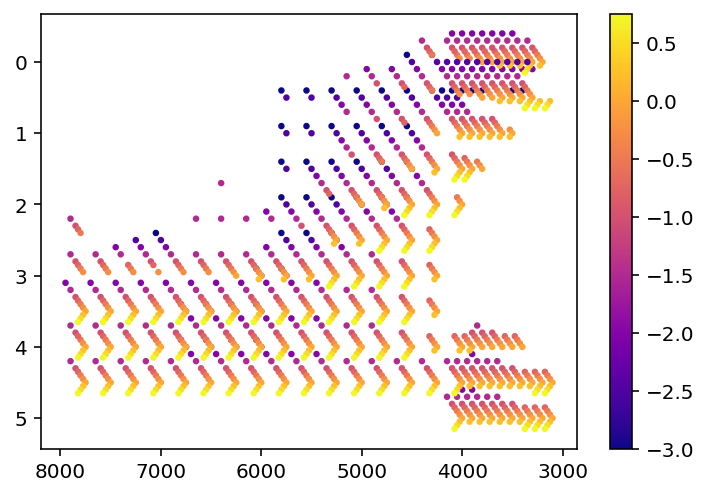

In [667]:
selection = trained_3x3x3

f, ax = plt.subplots()
s = ax.scatter(
    grids['teff_subgrid'][selection] + np.abs(100*grids['fe_h_subgrid'][selection]),
    grids['logg_subgrid'][selection] + 0.2*grids['fe_h_subgrid'][selection],
    c = grids['fe_h_subgrid'][selection], s = 5, cmap='plasma'
)
plt.colorbar(s, ax=ax)
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()
plt.close()

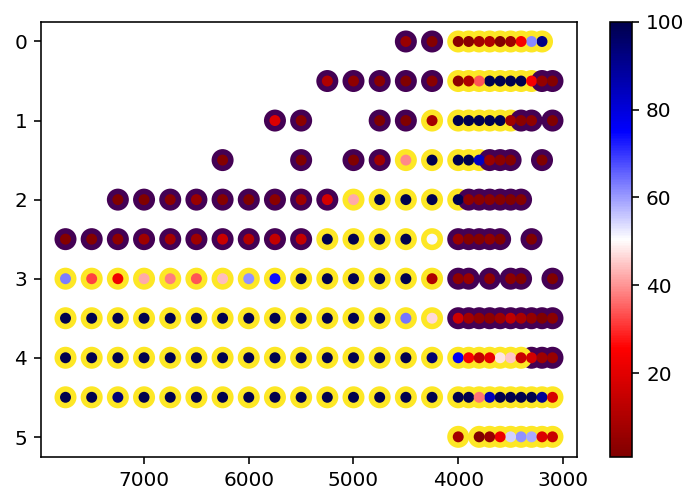

In [640]:
selection = (priority['fe_h_subgrid'] == -0.25) & (priority['counts_dr4_init'] >= 0)

done = []
for s in priority['index_subgrid'][selection]:
    if s in trained_3x3x3:
        done.append(1)
    else:
        done.append(0)

f, ax = plt.subplots()
s = ax.scatter(
    priority['teff_subgrid'][selection],
    priority['logg_subgrid'][selection],
    c = done,s=100,vmin=0,vmax=1
)
s = ax.scatter(
    priority['teff_subgrid'][selection],
    priority['logg_subgrid'][selection],
    c = priority['counts_dr4_init'][selection],vmax = 100, s=20,cmap='seismic_r'
)
plt.colorbar(s, ax=ax)
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()
plt.close()

In [641]:
parsec = Table.read('../auxiliary_information/parsec_isochrones/parsec_isochrones_logt_8p00_0p01_10p17_mh_m2p75_0p25_m0p75_mh_m0p60_0p10_0p70_GaiaEDR3_2MASS.fits')

1837, #  5500_4.50_-3.00
1875, #  5750_2.50_-3.00
1958, #  6000_2.50_-3.00
1982, #  6000_3.50_-3.00
2035, #  6250_2.50_-3.00
2120, #  6500_3.00_-3.00
2217, #  6750_4.00_-3.00
2229, #  6750_4.50_-3.00
2287, #  7000_4.00_-3.00
2392, #  7500_3.00_-3.00
2451, #  7750_3.00_-3.00


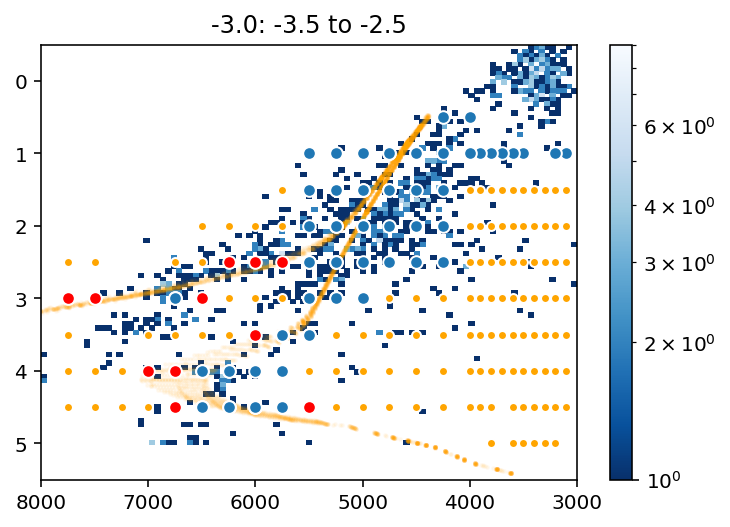

845, #  3700_5.00_-2.50
969, #  3800_5.00_-2.50
1092, #  3900_5.00_-2.50
1215, #  4000_5.00_-2.50
1743, #  5250_4.50_-2.50
1838, #  5500_4.50_-2.50
1876, #  5750_2.50_-2.50
1959, #  6000_2.50_-2.50
1983, #  6000_3.50_-2.50
2036, #  6250_2.50_-2.50
2060, #  6250_3.50_-2.50
2109, #  6500_2.50_-2.50
2121, #  6500_3.00_-2.50
2218, #  6750_4.00_-2.50
2230, #  6750_4.50_-2.50
2288, #  7000_4.00_-2.50
2331, #  7250_3.00_-2.50
2393, #  7500_3.00_-2.50
2452, #  7750_3.00_-2.50


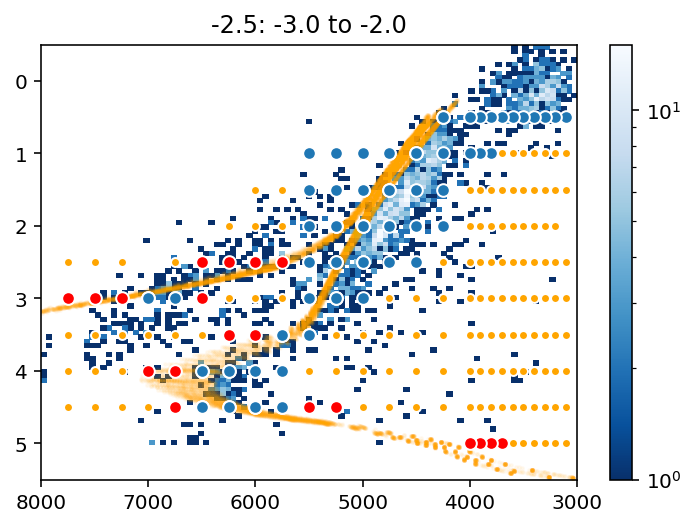

599, #  3500_5.00_-2.00
724, #  3600_5.00_-2.00
970, #  3800_5.00_-2.00
1093, #  3900_5.00_-2.00
1216, #  4000_5.00_-2.00
1877, #  5750_2.50_-2.00
1960, #  6000_2.50_-2.00
2037, #  6250_2.50_-2.00
2110, #  6500_2.50_-2.00
2122, #  6500_3.00_-2.00
2219, #  6750_4.00_-2.00
2231, #  6750_4.50_-2.00
2289, #  7000_4.00_-2.00
2394, #  7500_3.00_-2.00
2453, #  7750_3.00_-2.00


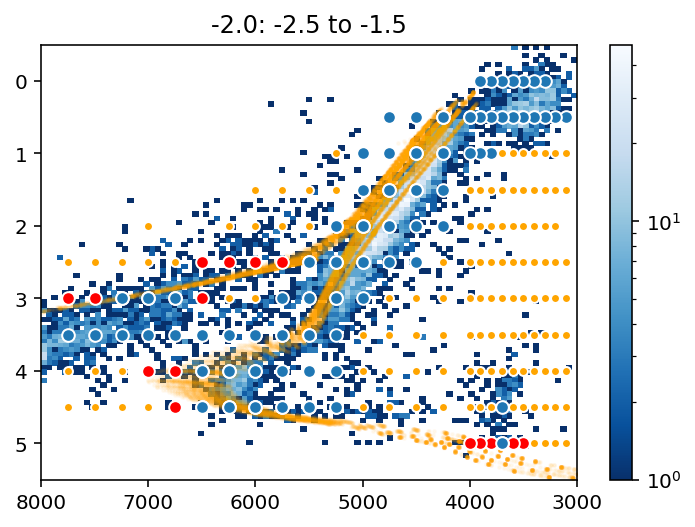

103, #  3100_5.00_-1.50
221, #  3200_5.00_-1.50
347, #  3300_5.00_-1.50
473, #  3400_5.00_-1.50


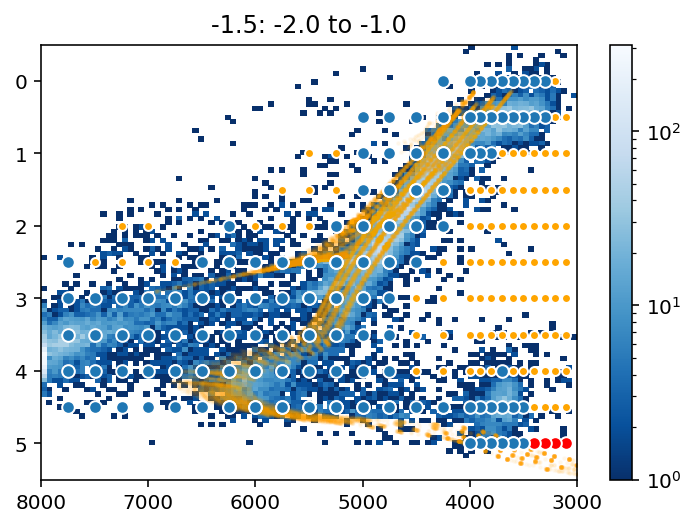

104, #  3100_5.00_-1.00
222, #  3200_5.00_-1.00
348, #  3300_5.00_-1.00


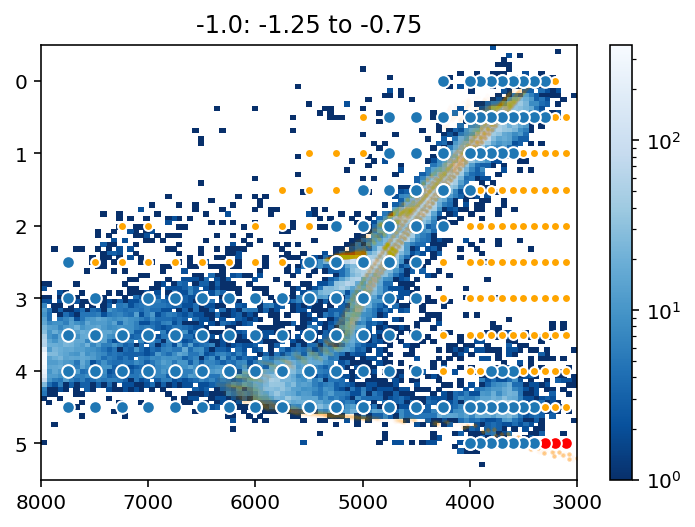

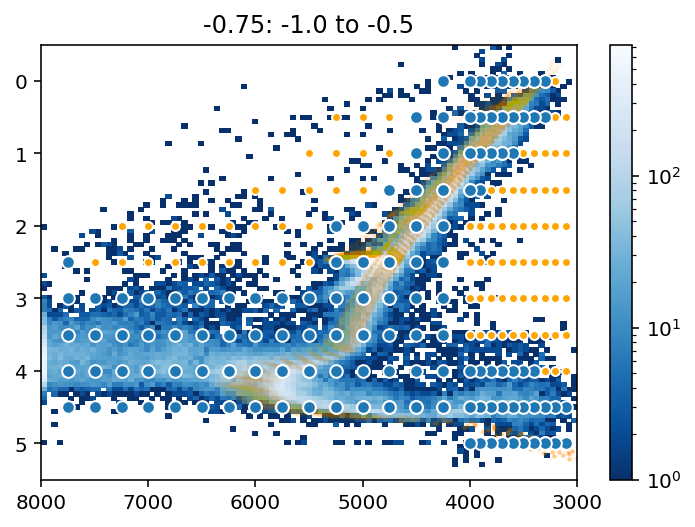

1688, #  5250_2.00_-0.50
1783, #  5500_2.00_-0.50
1795, #  5500_2.50_-0.50
1869, #  5750_2.00_-0.50
1881, #  5750_2.50_-0.50
1952, #  6000_2.00_-0.50
1964, #  6000_2.50_-0.50
2041, #  6250_2.50_-0.50
2114, #  6500_2.50_-0.50
2187, #  6750_2.50_-0.50


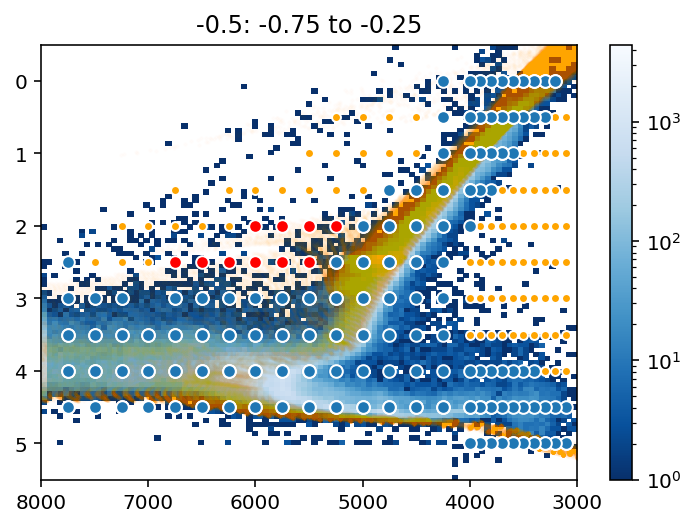

117, #  3200_0.50_-0.25
1226, #  4250_0.00_-0.25
1689, #  5250_2.00_-0.25
1796, #  5500_2.50_-0.25
1882, #  5750_2.50_-0.25
1965, #  6000_2.50_-0.25
2042, #  6250_2.50_-0.25
2115, #  6500_2.50_-0.25


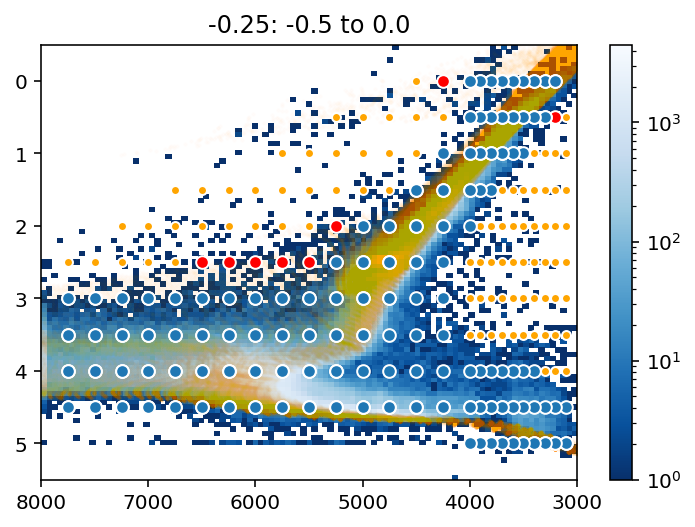

6, #  3100_0.50_0.00
118, #  3200_0.50_0.00
982, #  3900_0.00_0.00
992, #  3900_0.50_0.00
1105, #  4000_0.00_0.00
1227, #  4250_0.00_0.00
1797, #  5500_2.50_0.00
1883, #  5750_2.50_0.00
1966, #  6000_2.50_0.00
2043, #  6250_2.50_0.00
2116, #  6500_2.50_0.00
2128, #  6500_3.00_0.00
2201, #  6750_3.00_0.00
2271, #  7000_3.00_0.00
2337, #  7250_3.00_0.00
2400, #  7500_3.00_0.00
2459, #  7750_3.00_0.00


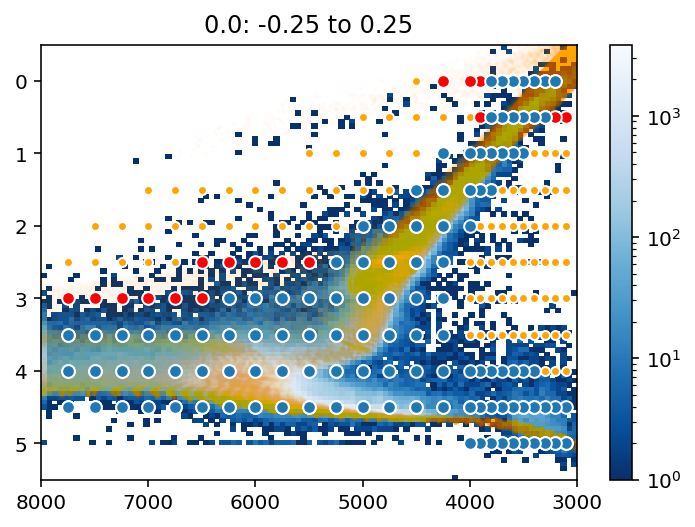

383, #  3400_1.00_0.25
719, #  3600_4.50_0.25
737, #  3700_0.00_0.25
747, #  3700_0.50_0.25
771, #  3700_1.50_0.25
842, #  3700_4.50_0.25
859, #  3800_0.00_0.25
869, #  3800_0.50_0.25
893, #  3800_1.50_0.25
965, #  3800_4.50_0.25
1371, #  4500_1.50_0.25
1798, #  5500_2.50_0.25
1884, #  5750_2.50_0.25
1967, #  6000_2.50_0.25
2044, #  6250_2.50_0.25
2056, #  6250_3.00_0.25
2117, #  6500_2.50_0.25
2129, #  6500_3.00_0.25
2202, #  6750_3.00_0.25
2272, #  7000_3.00_0.25
2338, #  7250_3.00_0.25
2401, #  7500_3.00_0.25
2460, #  7750_3.00_0.25


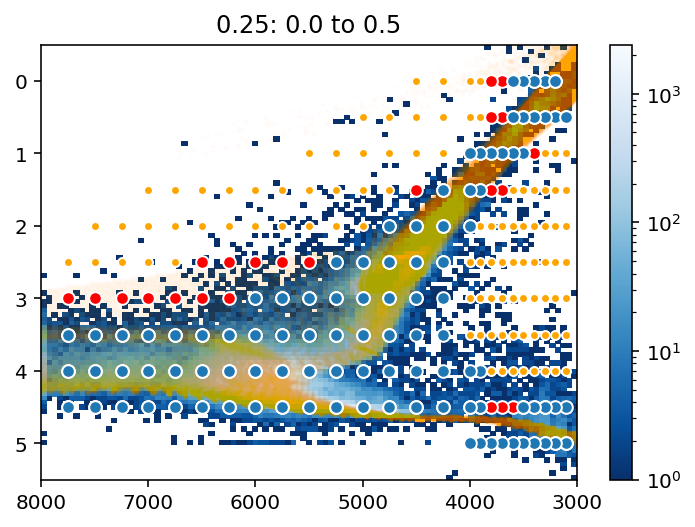

258, #  3300_1.00_0.50
342, #  3300_4.50_0.50
354, #  3300_5.00_0.50
363, #  3400_0.00_0.50
373, #  3400_0.50_0.50
384, #  3400_1.00_0.50
468, #  3400_4.50_0.50
480, #  3400_5.00_0.50
499, #  3500_0.50_0.50
511, #  3500_1.00_0.50
595, #  3500_4.50_0.50
607, #  3500_5.00_0.50
624, #  3600_0.50_0.50
636, #  3600_1.00_0.50
648, #  3600_1.50_0.50
720, #  3600_4.50_0.50
748, #  3700_0.50_0.50
760, #  3700_1.00_0.50
772, #  3700_1.50_0.50
843, #  3700_4.50_0.50
882, #  3800_1.00_0.50
894, #  3800_1.50_0.50
966, #  3800_4.50_0.50
1006, #  3900_1.00_0.50
1030, #  3900_2.00_0.50
1090, #  3900_4.50_0.50
1129, #  4000_1.00_0.50
1263, #  4250_1.50_0.50
1490, #  4750_2.00_0.50
1605, #  5000_2.50_0.50
1704, #  5250_2.50_0.50
1799, #  5500_2.50_0.50
1811, #  5500_3.00_0.50
1885, #  5750_2.50_0.50
1897, #  5750_3.00_0.50
1968, #  6000_2.50_0.50
1980, #  6000_3.00_0.50
2045, #  6250_2.50_0.50
2057, #  6250_3.00_0.50
2130, #  6500_3.00_0.50
2142, #  6500_3.50_0.50
2203, #  6750_3.00_0.50
2215, #  6750_3

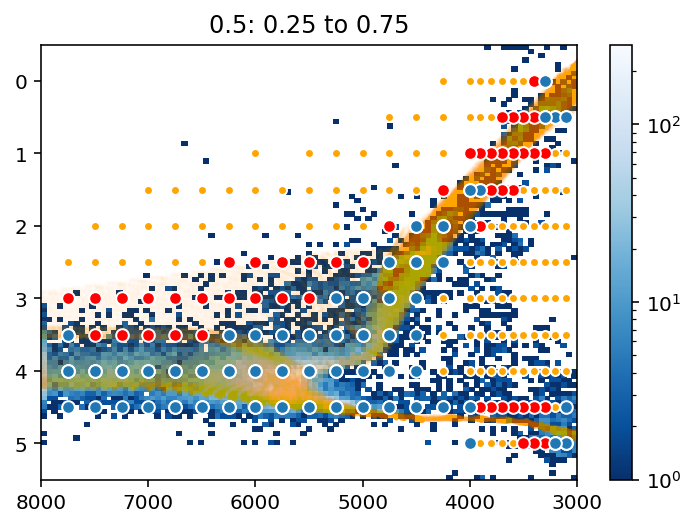

259, #  3300_1.00_0.75
343, #  3300_4.50_0.75
355, #  3300_5.00_0.75
374, #  3400_0.50_0.75
385, #  3400_1.00_0.75
469, #  3400_4.50_0.75
481, #  3400_5.00_0.75
500, #  3500_0.50_0.75
512, #  3500_1.00_0.75
596, #  3500_4.50_0.75
625, #  3600_0.50_0.75
637, #  3600_1.00_0.75
649, #  3600_1.50_0.75
721, #  3600_4.50_0.75
761, #  3700_1.00_0.75
773, #  3700_1.50_0.75
844, #  3700_4.50_0.75
883, #  3800_1.00_0.75
895, #  3800_1.50_0.75
967, #  3800_4.50_0.75
1007, #  3900_1.00_0.75
1031, #  3900_2.00_0.75
1091, #  3900_4.50_0.75
1264, #  4250_1.50_0.75
1606, #  5000_2.50_0.75
1705, #  5250_2.50_0.75
1800, #  5500_2.50_0.75
1812, #  5500_3.00_0.75
1886, #  5750_2.50_0.75
1898, #  5750_3.00_0.75
1969, #  6000_2.50_0.75
1981, #  6000_3.00_0.75
2058, #  6250_3.00_0.75
2131, #  6500_3.00_0.75
2143, #  6500_3.50_0.75
2204, #  6750_3.00_0.75
2216, #  6750_3.50_0.75
2274, #  7000_3.00_0.75
2286, #  7000_3.50_0.75
2340, #  7250_3.00_0.75
2351, #  7250_3.50_0.75
2403, #  7500_3.00_0.75
2414, #  750

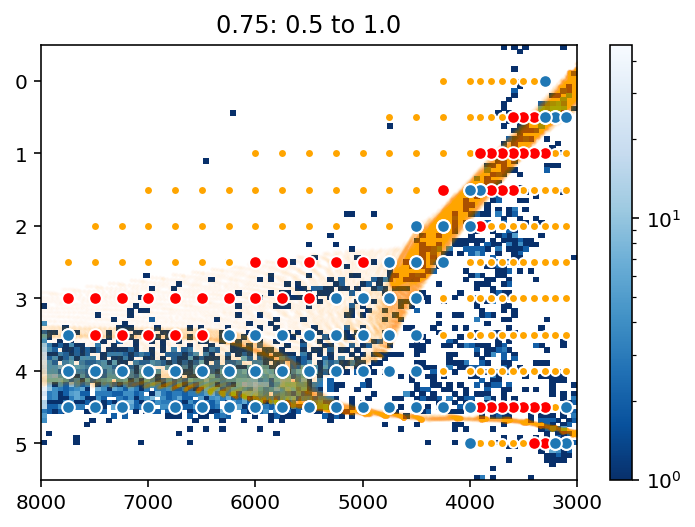

In [642]:
fe_h_array = np.unique(grids['fe_h_subgrid'])
# fe_h_array = [0.0]

print_point_models = True

for fe_h in fe_h_array:

    if fe_h < -0.5:
        age_low = 8
        age_high = 14
    else:
        age_low = 0.2
        age_high = 10

    d_fe_h = 0.25
    if fe_h < -1:
        d_fe_h = 0.5
    metallicity_range = (
        (initial_values['fe_h'] > fe_h-d_fe_h) &
        (initial_values['fe_h'] <= fe_h+d_fe_h) &
        np.isfinite(initial_values['fe_h'])
    )

    if len(initial_values['teff'][metallicity_range]) > 100:
        s = plt.hist2d(
            initial_values['teff'][metallicity_range],
            initial_values['logg'][metallicity_range],
            bins = (np.linspace(3000,8000,100),np.linspace(-0.5,5.5,100)),
            cmin = 1, cmap = 'Blues_r', norm=LogNorm()
        )
        plt.colorbar(s[-1])
    else:
        s = plt.scatter(
            initial_values['teff'][metallicity_range],
            initial_values['logg'][metallicity_range],
            c = 'k', s = 5
        )
        plt.colorbar()

    if fe_h < -1:
        alpha_fe = 0.4
    elif fe_h > 0:
        alpha_fe = 0.0
    else:
        alpha_fe = -0.4 *fe_h

    m_h = fe_h + np.log10(10**alpha_fe * 0.694 + 0.306)

    select_isochrone = (
        ((10**(parsec['logAge'] - 9) > age_low) &
        (10**(parsec['logAge'] - 9) < age_high)) &
        (parsec['m_h'] >= np.min([0.6,np.max([-2.2,m_h-d_fe_h])])) &
        (parsec['m_h'] <= np.min([0.7,np.max([-2.1,m_h+d_fe_h])]))
    )
    if fe_h < -1:
        alpha = 0.05
    else:
        alpha = 0.01
    plt.scatter(
        10**parsec['logT'][select_isochrone],
        parsec['logg'][select_isochrone],
        c = 'orange', s = 2,alpha = alpha
    )
    # plt.scatter(
    #     10**parsec['logT'][select_isochrone],
    #     parsec['logg'][select_isochrone],
    #     c = 'w', s = 0.5, alpha=0.2
    # )

    subgrid = (
        (grids['fe_h_subgrid'] == fe_h) #&
    #     (grids['teff_subgrid'] > 3500) &
    #     (grids['teff_subgrid'] < 7000)
    )

    trained = np.zeros(len(grids['teff_subgrid'][subgrid]))
    for index, grid in enumerate(grids['index_subgrid'][subgrid]):
        if grid in trained_3x3x3:
            trained[index] = 1
        elif grid in train_now:
            trained[index] = 2

    needed = []
    not_needed = []

    if fe_h in [-3.,-2.5,-2.,-1.5]: min_need = 25
    elif fe_h in [-1.]: min_need = 25
    else: min_need = 100

    for grid in grids[subgrid]:

        iso_points_nearby = np.where(
            (abs(grid['teff_subgrid'] - 10**parsec['logT'][select_isochrone]) < 125) &
            (abs(grid['logg_subgrid'] - parsec['logg'][select_isochrone]) < 0.25)
        )[0]
        if len(iso_points_nearby) > min_need:
            needed.append(grid['index_subgrid'])
            if print_point_models:
                if grid['index_subgrid'] not in trained_3x3x3:
                    print(str(grid['index_subgrid'])+', # ',grid['model_name'])
        else:
            not_needed.append(grid['index_subgrid'])



    plt.scatter(
        grids['teff_subgrid'][not_needed],
        grids['logg_subgrid'][not_needed],
        s = 20, c = 'orange', ec='w'
    )
    plt.scatter(
        grids['teff_subgrid'][needed],
        grids['logg_subgrid'][needed],
        s = 40, c = 'r', ec='w'
    )
    plt.scatter(
        grids['teff_subgrid'][subgrid][trained==1],
        grids['logg_subgrid'][subgrid][trained==1],
        s = 40, c = 'C0', ec='w'
    )
    plt.scatter(
        grids['teff_subgrid'][subgrid][trained==2],
        grids['logg_subgrid'][subgrid][trained==2],
        s = 40, c = 'green', ec='w'
    )

    plt.title(str(fe_h)+': '+str(fe_h-d_fe_h)+' to '+str(fe_h+d_fe_h))
    plt.xlim(8000,3000)
    plt.ylim(5.5,-0.5)
    plt.show()
    plt.close()

# initial_values[metal_poor][['sobject_id','tmass_id','flag_sp','flag_sp_fit','teff','logg','logg_spec','fe_h','model_name','closest_model']]

In [368]:
np.where(grids['model_name'] == '4250_1.00_-2.50')

(array([1242]),)

In [ ]:
fe_h_unique = np.unique(grids['fe_h_subgrid'])
s_fe_h_unique = np.arange((1+12)*0.75,1*0.75,-1*0.75)**2

norm = matplotlib.colors.Normalize(vmin=fe_h_unique[0], vmax=fe_h_unique[-1])
cmap = matplotlib.cm.get_cmap('plasma')

f, ax = plt.subplots()

kwargs = dict(vmin = fe_h_unique[0], vmax = fe_h_unique[-1], cmap = 'plasma')

for index in trained_3x3x3:

    s = ax.scatter(
        grids['teff_subgrid'][index],
        grids['logg_subgrid'][index],
        c = grids['fe_h_subgrid'][index],
        zorder = np.where(grids['fe_h_subgrid'][index] == fe_h_unique)[0][0],
        s = s_fe_h_unique[np.where(grids['fe_h_subgrid'][index] == fe_h_unique)[0][0]],
        **kwargs
    )

# [M/H] = -2, 13.5 Gyr
m_h_1_iso = parsec[
    (parsec['m_h'] == -2) &
    (10**(parsec['logAge']-9) > 13.4) &
    (10**(parsec['logAge']-9) < 13.5)
]
dex = 115
ax.plot(
    10**m_h_1_iso['logT'][:dex],
    m_h_1_iso['logg'][:dex],
    c = cmap(norm(-2)),
    zorder = 14, ls= 'dashed'
)
ax.plot(
    10**m_h_1_iso['logT'][dex:],
    m_h_1_iso['logg'][dex:],
    c = cmap(norm(-2)),
    zorder = 14, ls= 'dashed'
)

# [M/H] = -1, 11.0 Gyr
m_h_1_iso = parsec[
    (parsec['m_h'] == -1) &
    (10**(parsec['logAge']-9) > 10.9) &
    (10**(parsec['logAge']-9) < 11.1)
]
dex = 121
ax.plot(
    10**m_h_1_iso['logT'][:dex],
    m_h_1_iso['logg'][:dex],
    c = cmap(norm(-1)),
    zorder = 14, ls= 'dashed'
)
ax.plot(
    10**m_h_1_iso['logT'][dex:],
    m_h_1_iso['logg'][dex:],
    c = cmap(norm(-1)),
    zorder = 14, ls= 'dashed'
)

# [M/H] = -0.5, 10.0 Gyr
m_h_1_iso = parsec[
    (parsec['m_h'] == -0.5) &
    (10**(parsec['logAge']-9) > 9.9) &
    (10**(parsec['logAge']-9) < 10.1)
]
dex = 125
ax.plot(
    10**m_h_1_iso['logT'][:dex],
    m_h_1_iso['logg'][:dex],
    c = cmap(norm(-0.5)),
    zorder = 14, ls= 'dashed'
)
ax.plot(
    10**m_h_1_iso['logT'][dex:],
    m_h_1_iso['logg'][dex:],
    c = cmap(norm(-0.5)),
    zorder = 14, ls= 'dashed'
)

# [M/H] = 0.0, 4.5 Gyr
m_h_1_iso = parsec[
    (parsec['m_h'] == 0.0) &
    (10**(parsec['logAge']-9) > 4.4) &
    (10**(parsec['logAge']-9) < 4.6)
]
dex = 138
ax.plot(
    10**m_h_1_iso['logT'][:dex],
    m_h_1_iso['logg'][:dex],
    c = cmap(norm(-0.)),
    zorder = 14, ls= 'dashed'
)
ax.plot(
    10**m_h_1_iso['logT'][dex:],
    m_h_1_iso['logg'][dex:],
    c = cmap(norm(-0.)),
    zorder = 14, ls= 'dashed'
)

# [M/H] = 0.0, 1.0 Gyr
m_h_1_iso = parsec[
    (parsec['m_h'] == 0.0) &
    (10**(parsec['logAge']-9) > 0.985) &
    (10**(parsec['logAge']-9) < 1.015)
]
ax.plot(
    10**m_h_1_iso['logT'],
    m_h_1_iso['logg'],
    c = cmap(norm(-0.)),
    zorder = 14, ls= 'dashed'
)

# [M/H] = 0.5, 8 Gyr
m_h_1_iso = parsec[
    (parsec['m_h'] == 0.5) &
    (10**(parsec['logAge']-9) > 3.9) &
    (10**(parsec['logAge']-9) < 4.1)
]
dex = 144
ax.plot(
    10**m_h_1_iso['logT'][:dex],
    m_h_1_iso['logg'][:dex],
    c = cmap(norm(0.5)),
    zorder = 14, ls= 'dashed'
)
ax.plot(
    10**m_h_1_iso['logT'][dex:],
    m_h_1_iso['logg'][dex:],
    c = cmap(norm(0.5)),
    zorder = 14, ls= 'dashed'
)

ax.text(0.025,0.95,'[M/H] = -2.0, 13.5 Gyr',color = cmap(norm(-2)),transform=ax.transAxes)
ax.text(0.025,0.9,'[M/H] = -1.0, 11.0 Gyr',color = cmap(norm(-1)),transform=ax.transAxes)
ax.text(0.025,0.85,'[M/H] = -0.5, 10.0 Gyr',color = cmap(norm(-0.5)),transform=ax.transAxes)
ax.text(0.025,0.8,'[M/H] =  0.0,   4.5 Gyr',color = cmap(norm(0)),transform=ax.transAxes)
ax.text(0.025,0.75,'[M/H] =  0.0,   1.0 Gyr',color = cmap(norm(0)),transform=ax.transAxes)
ax.text(0.025,0.7,'[M/H] =  0.5,   4.0 Gyr',color = cmap(norm(0.5)),transform=ax.transAxes)

cbar = plt.colorbar(s,ax=ax)
cbar.set_label('[Fe/H]',fontsize=15)
ax.set_xlim(8000,3000)
ax.set_ylim(5.25,-0.25)
ax.set_xlabel(r'$T_\mathrm{eff}~/~\mathrm{K}$',fontsize=15)
ax.set_ylabel(r'$\log (g~/~\mathrm{cm\,s^{-2}})$',fontsize=15)
plt.tight_layout()
plt.savefig('../validation/figures/NN_grid_coverage.png',bbox_inches='tight',dpi=200)